**Section c)**

In [1]:
#Creation of the dependent and independent terms
import numpy as np
nsample=500     #Number of observations
nvariables=20   #Number of variables
#We make results reproducible in order to obtain always the same random values
np.random.seed(0) 
X0=np.ones([nsample,1])
X1=np.random.uniform(0,10,([nsample,nvariables]))
X=np.concatenate([X0,X1],axis=1)  #Design Matrix
error=np.random.normal(0,1,(nsample,1))
beta=np.random.randint(-5,5,size=([nvariables+1,1]));
Y=np.dot(X,beta)+error

In [10]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

model=AbstractModel()

model.I = RangeSet(1,nsample)       #Index for observations
model.J = RangeSet(1,nvariables+1)  #Index for variables plus the independent term

model.k= Param(within=NonNegativeIntegers,default=2,mutable=True)

model.beta_la = Var(model.J,domain=Reals,bounds=(-5,5))
model.t = Var(model.I,domain=NonNegativeReals)
model.z = Var(model.J,domain=Binary)  

def Obj_rule(model):
	return sum(model.t[i] for i in model.I)
model.OBJ = Objective(rule=Obj_rule, sense=minimize)

def abs_constraint_upper(model, i): 
    return -(sum((model.beta_la[j]*X[i-1,j-1]) for j in model.J))-model.t[i]<=-Y[i-1]
model.abs_Constraint_up = Constraint(model.I, rule=abs_constraint_upper)

def abs_constraint_lower(model, i): 
    return -(sum((model.beta_la[j]*X[i-1,j-1]) for j in model.J))+model.t[i]>=-Y[i-1]
model.abs_Constraint_low = Constraint(model.I, rule=abs_constraint_lower)
def z_constraint(model,j):
    if(j==1):
        return model.z[j]==1
    else:
        return sum (model.z[j] for j in model.J if(j!=1)) == model.k
model.z_Constraint = Constraint(model.J, rule=z_constraint)
        
def beta_constraint_upper(model,j):
    return model.beta_la[j]<=5*model.z[j]
model.beta_Constraint_up = Constraint(model.J, rule=beta_constraint_upper)

def beta_constraint_lower(model,j):
    return model.beta_la[j]>=-5*model.z[j]
model.beta_Constraint_low = Constraint(model.J, rule=beta_constraint_lower)

In [38]:
instance=model.create_instance()
Obj_f=[]
k_range = list(range(1, 21))
for k in k_range:
    getattr(instance, "k").set_value(k)
    results=opt.solve(instance)
    #print(results)
    Obj_f.append(instance.OBJ())
    print("Objective function [k=%d] = %f" %(k,instance.OBJ()))
    #for j in sequence(1,nvariables+1):
    #for j in instance.J:
        #print("Beta_least_absolute: %.4f;\tBeta_least_square: %.4f;\tDifference: %.4f" %(instance.beta_la[j].value,beta_ls[j-1],np.subtract(instance.beta_la[j].value,beta_ls[j-1])))
        #print("Beta[%d]= %f"%(j-1,instance.beta_la[j].value))
print(Obj_f)

Objective function [k=1] = 29301.415527
Objective function [k=2] = 17925.023188
Objective function [k=3] = 10285.417756
Objective function [k=4] = 8517.900167
Objective function [k=5] = 7467.925471
Objective function [k=6] = 6518.818797
Objective function [k=7] = 5524.092170
Objective function [k=8] = 5029.030094
Objective function [k=9] = 4463.602358
Objective function [k=10] = 3957.622210
Objective function [k=11] = 3393.144298
Objective function [k=12] = 2582.438089
Objective function [k=13] = 2316.316451
Objective function [k=14] = 1919.524851
Objective function [k=15] = 1564.084613
Objective function [k=16] = 1199.839979
Objective function [k=17] = 368.878102
Objective function [k=18] = 368.241161
Objective function [k=19] = 367.827198
Objective function [k=20] = 367.819393
[29301.41552702537, 17925.023187752802, 10285.417756218136, 8517.900166764393, 7467.92547054554, 6518.818796890404, 5524.092169747568, 5029.030093646303, 4463.602358458411, 3957.6222100704426, 3393.144298198247

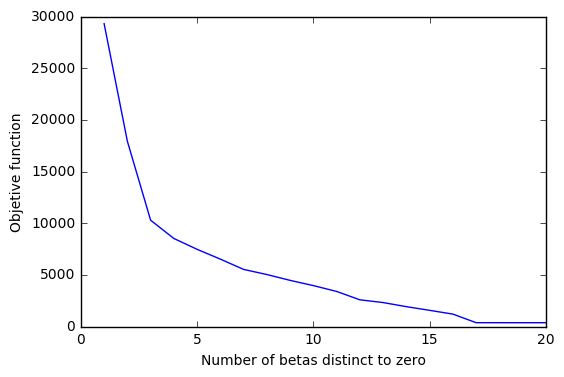

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.array(k_range,dtype=float), Obj_f)
plt.ylabel('Objetive function')
plt.xlabel('Number of betas distinct to zero')
plt.show()